<a href="https://colab.research.google.com/github/danplotkin/mastering_rl/blob/main/mastering_rl_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mastering Reinforcement Learning: Theory, Math, and Python
>  _**Part II: Implementing Reiforcement Learning in Python**_

> *Author:  Daniel M. Plotkin*

> *Author Email: danmplotkin@gmail.com*

> *Last Updated: 1/13/2024*

> **[Click to Access Course Homepage](https://github.com/danplotkin/mastering_rl?tab=readme-ov-file#understanding-reinforcement-learning)**

# Table of Contents

>[Mastering Reinforcement Learning: Theory, Math, and Python](#folderId=1f4HcgYX5w3A2WnXtuemcRsNKbkm4QvvJ&updateTitle=true&scrollTo=D7MsrzHjdsbW)

>[Table of Contents](#folderId=1f4HcgYX5w3A2WnXtuemcRsNKbkm4QvvJ&updateTitle=true&scrollTo=VKrTooqGe8Y4)



# Gynmasium

Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms by providing an API all single agent reinforcement learning environments. Gymnasium is a maintained fork of OpenAI's Gym library. Check out their [documentation](https://gymnasium.farama.org/) for more.

# The Cartpole Envirnonment

The Cartpole environment is on of the most well known classic reinforcement learning problems offered within the Gynmasium library. It's a simple simulation where a pole is attached to a cart, and the goal is to balance the pole by moving the cart left or right.


<img src="https://bytepawn.com/images/cartpole.gif" alt="Alt text" width="600" height="400" />

> [*Gif Source*](https://bytepawn.com/images/cartpole.gif)

A reward $r_t+1 = 1$ is provided for every time step the pole remains upright. The episode will end when:
- The pole tips over at a certain angle limit.
- The cart moves outside the world edges.
- A maximum number of time steps is reached.

The goal is to learn a policy that is able to maximize the sum of rewards in an episode.

# Developing a Cartpole Agent

We will now implement our agent using `gynmasium` and `pytorch`.

## Install Gymnasium

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.4 MB/s eta 0:00:00


## Import Required Libaries

In [2]:
import gymnasium as gym

import random
import math
from collections import namedtuple, deque
from itertools import count
from copy import deepcopy
from tqdm.auto import tqdm
from dataclasses import dataclass

import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Specify GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set plotting grid size
plt.rcParams['figure.figsize'] = (10, 6)

## Initialize Envirnonment

In [3]:
env = gym.make("CartPole-v1")

## Create Replay Memory

We will initialize our replay memory, which is where we store the agent's experiences at each time step. We will intiaize two classes:

* `Transition` - This will be a named tuple mapping our state-action pairs $(s_t, s_t)$ to their next state and reward $(s_{t+1}, r_{t+1})$.

* `ReplayMemory` - A Buffer of a bounded to a size that holds the transitions observed recently. We will also allow our class to randomly a random batch for traning.

In [4]:
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward')
)


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """
        Save a transition into memory.
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """
        Randomly sample a batch from memory.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Build Deep Q-Network

In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_observations, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions)
        )

        # Use He initialization for weights
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                torch.nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')

    def forward(self, x):
        return self.network(x)

## Define Hyperparameters

We need to define some hyperparameters to train our agent. Instead of just blindly creating variables, we will organize our configurations in a `dataclass` decorator. This allows our hyperparameters to be in one place.

In [6]:
@dataclass
class Config:
    """
    Configuration class defining hyperparameters and environment properties.

    Attributes:
        batch_size (int): The size of each mini-batch for training.
        gamma (float): The discount factor determining the importance of future rewards.
        eps_start (float): The starting exploration rate for epsilon-greedy action selection.
        eps_end (float): The final exploration rate for epsilon-greedy action selection.
        eps_decay (int): The rate at which the exploration rate decays.
        tau (float): The factor determining the update rate of target network parameters.
        lr (float): The learning rate for the optimizer.
        n_actions (int): The number of possible actions in the environment's action space.
        n_observations (int): The number of observations in the environment's state space.
        num_episodes (int): The number of episodes to train our agent.
    """
    batch_size: int = 128
    gamma: float = 0.99
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay: int = 1000
    tau: float = 1e-3
    lr: float = 1e-3
    n_actions: int = env.action_space.n
    n_observations: int = env.observation_space.shape[0]
    num_episodes: int = 500

# Create config instance
configs = Config()
print(configs)

Config(batch_size=128, gamma=0.99, eps_start=1.0, eps_end=0.05, eps_decay=1000, tau=0.001, lr=0.001, n_actions=2, n_observations=4, num_episodes=500)


## Define Policy and Target Network

In [7]:
# Define Networks
policy_net = DQN(configs.n_observations, configs.n_actions).to(device)
target_net = deepcopy(policy_net)

# Define Policy Network Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=configs.lr)

# Intialize memory
memory = ReplayMemory(10000)

# Define criterion
criterion = nn.MSELoss()

## Train Agent

### 1. Create Agent Class

We will create a class called `Agent` where we can implement our training and evaulation methods for our agent. Our agent at the least should be able to select an action, train our agent via looping through episodes and optimizing our networks, and evaluate our network without gradient computation.

In [8]:
class Agent:
    def __init__(self, env, policy_net, target_net, optimizer, criterion,
                 memory, training_configs, transition_tuple, device):
        """
        Initializes a Deep Q Network (DQN) agent.

        Parameters:
            env: The environment in which the agent interacts.
            policy_net: The neural network representing the agent's policy.
            target_net: The target neural network used for Q-value target estimation.
            optimizer: The optimizer used for updating the policy network.
            criterion: The loss criterion for training the policy network.
            memory: Replay buffer for storing and sampling experiences.
            training_configs: Configuration parameters for the training process.
            transition_tuple: Named tuple for representing transitions in the replay buffer.
            device: The device (CPU or GPU) on which the agent operates.

        Attributes:
            env: The environment in which the agent interacts.
            policy_net: The neural network representing the agent's policy.
            target_net: The target neural network used for Q-value target estimation.
            optimizer: The optimizer used for updating the policy network.
            criterion: The loss criterion for training the policy network.
            memory: Replay buffer for storing and sampling experiences.
            training_configs: Configuration parameters for the training process.
            transition_tuple: Named tuple for representing transitions in the replay buffer.
            device: The device (CPU or GPU) on which the agent operates.
            steps_done: Counter for the total number of agent steps taken.
            episode_durations: List to store durations of completed episodes.
        """
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.criterion = criterion
        self.memory = memory
        self.training_configs = training_configs
        self.transition_tuple = transition_tuple
        self.device = device
        self.steps_done = 0
        self.episode_durations = []

    def select_action(self, state, training=False):
        """
        Selects an action using an epsilon-greedy method.

        Parameters:
            state: The current state of the environment.
            training: Boolean telling if it is in training or not. False by defualt.
        """
        # Get parameters from training configs
        eps_start = self.training_configs.eps_start
        eps_end = self.training_configs.eps_end
        eps_decay = self.training_configs.eps_decay

        # Sample random floating point number
        r = random.random()

        # Decay epsilon
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1. * self.steps_done / eps_decay)
        if training:
            self.steps_done += 1

        # Epsilon-greedy strategy
        if r > eps_threshold:
            with torch.no_grad():
                # Get the index of the action with the maximum value
                return self.policy_net(state).argmax(1).view(1, 1)
        else:
            return torch.tensor(self.env.action_space.sample(),
                                device=self.device,
                                dtype=torch.long).view(1, 1)

    def _optimize(self):
        """
        Performs optimization on the policy network using a mini-batch of experiences.
        """
        if len(self.memory) < self.training_configs.batch_size:
            return None

        # Sample a random batch
        transitions = self.memory.sample(self.training_configs.batch_size)

        # Transpose the batch into named tuple format
        batch = self.transition_tuple(*zip(*transitions))

        # Compute a mask of non-terminal states
        non_terminal_mask = torch.tensor(tuple(map(
            lambda s: s is not None, batch.next_state
        )), device=self.device, dtype=torch.bool)

        # Compute a mask of non-terminal next states
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])

        # Concat the batch elements
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute state-action values
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Get next state values
        with torch.no_grad():
            next_state_values = torch.zeros(self.training_configs.batch_size, device=self.device)
            next_state_values[non_terminal_mask] = self.target_net(non_terminal_next_states).max(1).values

        # Compute the expected Q values with Bellman equation
        expected_state_action_values = reward_batch + (self.training_configs.gamma * next_state_values)

        # Compute loss
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def train(self, plot_training=True):
        """
        Executes the training loop for a specified number of episodes.

        Parameters:
            plot_training (bool): Plots training episodes after training loop.
        """
        self.policy_net.train()
        self.target_net.train()
        for episode in tqdm(range(self.training_configs.num_episodes)):

            # Initialize envirnonment and get the state
            state, info = self.env.reset()
            state = torch.tensor(state, device=self.device).unsqueeze(0)
            for t in count():
                action = self.select_action(state, training=True)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([reward], device=self.device)
                done = truncated or terminated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, device=self.device, dtype=torch.float32).unsqueeze(0)

                # Store transtion in memory
                self.memory.push(state, action, next_state, reward)

                # s_t -> s_{t+1}
                state = next_state

                # One step optimization on policy network
                self._optimize()

                # Soft update target net parameters
                target_net_params = self.target_net.state_dict()
                policy_net_params = self.policy_net.state_dict()
                for key in policy_net_params:
                    tau = self.training_configs.tau
                    target_net_params[key] = policy_net_params[key] * tau + target_net_params[key] * (1-tau)
                self.target_net.load_state_dict(target_net_params)

                if done:
                    self.episode_durations.append(t + 1)
                    break

        if plot_training:
            self.plot_training()

    @torch.no_grad()
    def evaluate(self, num_episodes=10, return_df=False, print_df=True):
        """
        Evaluates the trained DQN agent over a specified number of episodes.

        Parameters:
            num_episodes (int): Number of episodes for evaluation.
            return_df (bool): Returns dataframe if True.
            print_df (bool): Prints dataframe if True.
        """
        episode_durations = []

        self.policy_net.eval()
        self.target_net.eval()
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            state = torch.tensor(state, device=self.device).unsqueeze(0)

            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = self.env.step(action.item())

                if terminated:
                    episode_durations.append(t + 1)
                    break

                state = torch.tensor(observation, device=self.device, dtype=torch.float32).unsqueeze(0)

        # Print or log evaluation results
        df = pd.DataFrame(
            list(zip(np.arange(num_episodes)+1, episode_durations)),
            columns=['Episode', 'Duration']
        )
        if print_df:
            print(tabulate(df, tablefmt='pretty', headers='keys', showindex=False))

        avg_duration = sum(episode_durations) / num_episodes
        print(f'Average duration over {num_episodes} episodes: {avg_duration}')

        if return_df:
            return df

    def plot_training(self):
        """
        Plots training durations for each episode.
        """
        plt.plot(self.episode_durations)
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.title('Episode Durations')
        plt.show()

### 2. Intialize Agent

We will initialize our agent using our `Agent` class.

In [9]:
# Create agent instance
agent = Agent(
    env=env,
    policy_net=policy_net,
    target_net=target_net,
    optimizer=optimizer,
    criterion=criterion,
    memory=memory,
    training_configs=configs,
    transition_tuple=Transition,
    device=device
)

# Get an initial evaluation
agent.evaluate()

+---------+----------+
| Episode | Duration |
+---------+----------+
|    1    |    12    |
|    2    |    30    |
|    3    |    18    |
|    4    |    49    |
|    5    |    27    |
|    6    |    14    |
|    7    |    14    |
|    8    |    16    |
|    9    |    28    |
|   10    |    19    |
+---------+----------+
Average duration over 10 episodes: 22.7


### 3. Train Agent

We will use the `train()` method to train our agent.

  0%|          | 0/500 [00:00<?, ?it/s]

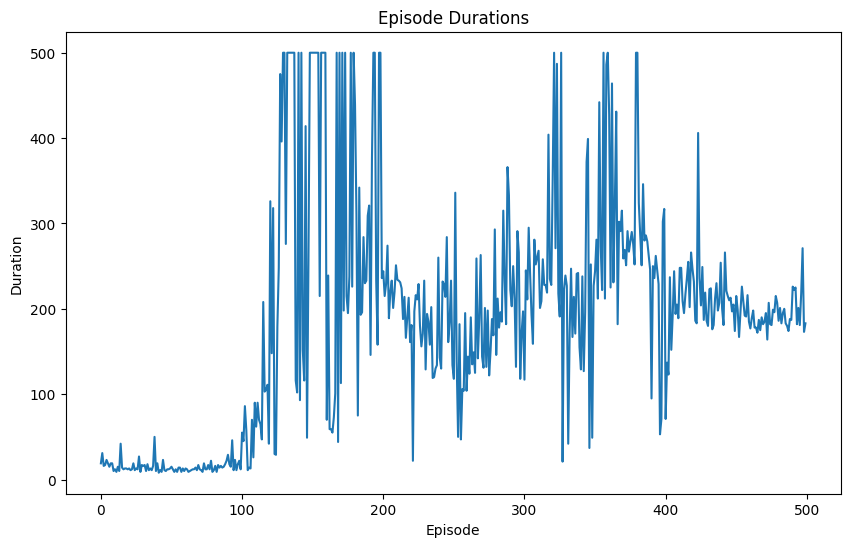

In [10]:
agent.train()

### 4. Evaluate Agent

In [11]:
agent.evaluate()

+---------+----------+
| Episode | Duration |
+---------+----------+
|    1    |   180    |
|    2    |   188    |
|    3    |   182    |
|    4    |   189    |
|    5    |   184    |
|    6    |   183    |
|    7    |   177    |
|    8    |   179    |
|    9    |   173    |
|   10    |   174    |
+---------+----------+
Average duration over 10 episodes: 180.9


We can see that through training, we can see our agent improved its strategy and performance of Cart Pole through training! We see this in the increase in episode durations during our evaluation episodes.

> **[Click to Access Course Homepage](https://github.com/danplotkin/mastering_rl?tab=readme-ov-file#understanding-reinforcement-learning)**